# Análisis de accidentes de tráfico en Madrid 2019

En este proyecto se realiza un extensa **exploración** y **análisis de los datos** de **accidentes de tráfico en Madrid en el año 2019**, realizándose después **predicciones** de atributos con algoritmos de **Machine Learning** y de **series de tiempo** con **redes neuronales** utilizando **tensorflow/keras.**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [147]:
df = pd.read_excel('E:\\Datasets\\2019_Accidentalidad.xlsx')
df.head()

,Nº EXPEDIENTE,FECHA,HORA,CALLE,NÚMERO,DISTRITO,TIPO ACCIDENTE,ESTADO METEREOLÓGICO,TIPO VEHÍCULO,TIPO PERSONA,RANGO EDAD,SEXO,LESIVIDAD*,* La correspondencia de los códigos se encuentra descrito en la estructura del fichero.
0,2019S000020,01/01/2019,23:30:00,CALL. FUENCARRAL,149,CHAMBERÍ,Caída,Despejado,Ciclomotor,Conductor,DE 25 A 29 AÑOS,Hombre,1.0,NaN
1,2019S000017,01/01/2019,22:15:00,CALL. OCA / CALL. PINZON,-,CARABANCHEL,Colisión fronto-lateral,Despejado,Turismo,Conductor,DE 40 A 44 AÑOS,Mujer,14.0,NaN
2,2019S000017,01/01/2019,22:15:00,CALL. OCA / CALL. PINZON,-,CARABANCHEL,Colisión fronto-lateral,Despejado,Ciclomotor,Conductor,DE 35 A 39 AÑOS,Hombre,3.0,NaN
3,2019S001812,01/01/2019,21:40:00,CALL. BAILEN / CUSTA. SAN VICENTE,-,CENTRO,Colisión fronto-lateral,Despejado,Turismo,Conductor,DE 40 A 44 AÑOS,Hombre,14.0,NaN
4,2019S001812,01/01/2019,21:40:00,CALL. BAILEN / CUSTA. SAN VICENTE,-,CENTRO,Colisión fronto-lateral,Despejado,Turismo,Conductor,DE 30 A 34 AÑOS,Mujer,7.0,NaN


In [4]:
#Eliminacion de atributo
del df['* La correspondencia de los códigos se encuentra descrito en la estructura del fichero.']

In [148]:
profile = ProfileReport(df, title='Pandas Profiling Report', html={'style':{'full_width':True}})
profile.to_notebook_iframe()

In [5]:
# Crear columnas de mes y dia con la informacion de FECHA simplificada

df['FECHA'] = df['FECHA'].astype('datetime64[ns]')

df['MES'] = df.FECHA.dt.month

df['DIA'] = df.FECHA.dt.day

df['DIA_NOMBRE'] = df.FECHA.dt.day_name()

In [6]:
df.head(2)

,Nº EXPEDIENTE,FECHA,HORA,CALLE,NÚMERO,DISTRITO,TIPO ACCIDENTE,ESTADO METEREOLÓGICO,TIPO VEHÍCULO,TIPO PERSONA,RANGO EDAD,SEXO,LESIVIDAD*,MES,DIA,DIA_NOMBRE
0,2019S000020,2019-01-01,23:30:00,CALL. FUENCARRAL,149,CHAMBERÍ,Caída,Despejado,Ciclomotor,Conductor,DE 25 A 29 AÑOS,Hombre,1.0,1,1,Tuesday
1,2019S000017,2019-01-01,22:15:00,CALL. OCA / CALL. PINZON,-,CARABANCHEL,Colisión fronto-lateral,Despejado,Turismo,Conductor,DE 40 A 44 AÑOS,Mujer,14.0,1,1,Tuesday


In [7]:
# Crear columnas de Mes y dia con la informacion de FECHA simplificada
df['FECHA'] = df['FECHA'].astype('datetime64[ns]')

df['MES'] = df.FECHA.dt.month

df['DIA'] = df.FECHA.dt.day

df['DIA_NOMBRE'] = df.FECHA.dt.weekday_name

## Evaluacion de valores perdidos/missings

In [8]:
df.replace("-", np.nan, inplace = True)
df.replace("Se desconoce", np.nan, inplace = True)
df.replace("Sin especificar", np.nan, inplace = True)
df.replace("DESCONOCIDA", np.nan, inplace = True)
df.replace("", np.nan, inplace = True)


In [9]:
#Cambiar numeracion por etiqueta en atributo 'LESIVIDAD*'

df['LESIVIDAD*'].replace([1,2,5,6,7],'LEVE', inplace = True)
df['LESIVIDAD*'].replace(3,'GRAVE', inplace = True)
df['LESIVIDAD*'].replace(4,'FALLECIDO', inplace = True)
df['LESIVIDAD*'].replace(77,'Se desconoce', inplace = True)
df['LESIVIDAD*'].replace([14, np.nan],'Sin asistencia sanitaria', inplace = True)
df.head(2)

,Nº EXPEDIENTE,FECHA,HORA,CALLE,NÚMERO,DISTRITO,TIPO ACCIDENTE,ESTADO METEREOLÓGICO,TIPO VEHÍCULO,TIPO PERSONA,RANGO EDAD,SEXO,LESIVIDAD*,MES,DIA,DIA_NOMBRE
0,2019S000020,2019-01-01,23:30:00,CALL. FUENCARRAL,149,CHAMBERÍ,Caída,Despejado,Ciclomotor,Conductor,DE 25 A 29 AÑOS,Hombre,LEVE,1,1,Tuesday
1,2019S000017,2019-01-01,22:15:00,CALL. OCA / CALL. PINZON,NaN,CARABANCHEL,Colisión fronto-lateral,Despejado,Turismo,Conductor,DE 40 A 44 AÑOS,Mujer,Sin asistencia sanitaria,1,1,Tuesday


## Data Wrangling

### Division de variables en numericas y categoricas

In [10]:
lista_numericas = df._get_numeric_data().columns

In [11]:
df_num = df[lista_numericas].head(2)

In [12]:
df_cat = df.drop(lista_numericas, axis=1)
df_cat.head(3)

,Nº EXPEDIENTE,FECHA,HORA,CALLE,NÚMERO,DISTRITO,TIPO ACCIDENTE,ESTADO METEREOLÓGICO,TIPO VEHÍCULO,TIPO PERSONA,RANGO EDAD,SEXO,LESIVIDAD*,DIA_NOMBRE
0,2019S000020,2019-01-01,23:30:00,CALL. FUENCARRAL,149,CHAMBERÍ,Caída,Despejado,Ciclomotor,Conductor,DE 25 A 29 AÑOS,Hombre,LEVE,Tuesday
1,2019S000017,2019-01-01,22:15:00,CALL. OCA / CALL. PINZON,NaN,CARABANCHEL,Colisión fronto-lateral,Despejado,Turismo,Conductor,DE 40 A 44 AÑOS,Mujer,Sin asistencia sanitaria,Tuesday
2,2019S000017,2019-01-01,22:15:00,CALL. OCA / CALL. PINZON,NaN,CARABANCHEL,Colisión fronto-lateral,Despejado,Ciclomotor,Conductor,DE 35 A 39 AÑOS,Hombre,GRAVE,Tuesday


### Creación de atributos día y mes

In [13]:
import datetime as dt
import calendar 

df_cat['HORA'] = df['HORA'].astype(str)
df_cat['HORA'] = [i[0:2] for i in df_cat['HORA']]

df_cat['MES'] = df['FECHA'].dt.month
df_cat['DIA'] = df['FECHA'].dt.day

df_cat.head(2)

,Nº EXPEDIENTE,FECHA,HORA,CALLE,NÚMERO,DISTRITO,TIPO ACCIDENTE,ESTADO METEREOLÓGICO,TIPO VEHÍCULO,TIPO PERSONA,RANGO EDAD,SEXO,LESIVIDAD*,DIA_NOMBRE,MES,DIA
0,2019S000020,2019-01-01,23,CALL. FUENCARRAL,149,CHAMBERÍ,Caída,Despejado,Ciclomotor,Conductor,DE 25 A 29 AÑOS,Hombre,LEVE,Tuesday,1,1
1,2019S000017,2019-01-01,22,CALL. OCA / CALL. PINZON,NaN,CARABANCHEL,Colisión fronto-lateral,Despejado,Turismo,Conductor,DE 40 A 44 AÑOS,Mujer,Sin asistencia sanitaria,Tuesday,1,1


In [15]:
#Copiar variables para que no se cambien con dummies

df_copia = pd.concat((df_cat['MES'],df_cat['DIA'],df_cat['HORA']),axis =1)

df_cat = df_cat[['DISTRITO','TIPO ACCIDENTE','ESTADO METEREOLÓGICO','TIPO VEHÍCULO','TIPO PERSONA','RANGO EDAD','SEXO','LESIVIDAD*']]

df_cat = pd.concat((df_cat,df_copia),axis=1)
df_cat.head(3)

,DISTRITO,TIPO ACCIDENTE,ESTADO METEREOLÓGICO,TIPO VEHÍCULO,TIPO PERSONA,RANGO EDAD,SEXO,LESIVIDAD*,MES,DIA,HORA
0,CHAMBERÍ,Caída,Despejado,Ciclomotor,Conductor,DE 25 A 29 AÑOS,Hombre,LEVE,1,1,23
1,CARABANCHEL,Colisión fronto-lateral,Despejado,Turismo,Conductor,DE 40 A 44 AÑOS,Mujer,Sin asistencia sanitaria,1,1,22
2,CARABANCHEL,Colisión fronto-lateral,Despejado,Ciclomotor,Conductor,DE 35 A 39 AÑOS,Hombre,GRAVE,1,1,22


## Exploración y análisis de los datos

**Picos en el año donde hay más accidentes**


[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '4'),
 Text(0, 0, '5'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12')]

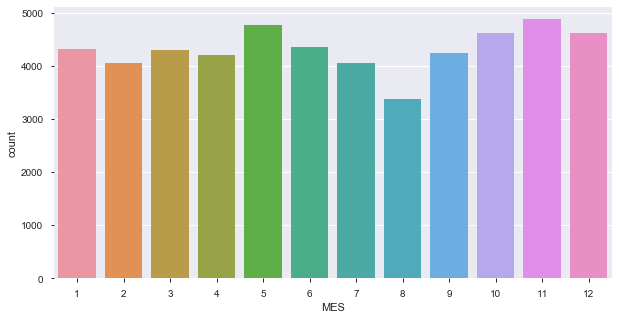

In [32]:
plt.figure(figsize=(10,5))
g = sns.countplot(x="MES", data=df_cat)
g.set_xticklabels(g.get_xticklabels())

**Distritos con más accidentes**


[Text(0, 0, 'SALAMANCA'),
 Text(0, 0, 'PUENTE DE VALLECAS'),
 Text(0, 0, 'CHAMARTÍN'),
 Text(0, 0, 'CARABANCHEL'),
 Text(0, 0, 'CIUDAD LINEAL'),
 Text(0, 0, 'SAN BLAS-CANILLEJAS'),
 Text(0, 0, 'CENTRO'),
 Text(0, 0, 'MONCLOA-ARAVACA'),
 Text(0, 0, 'CHAMBERÍ'),
 Text(0, 0, 'RETIRO'),
 Text(0, 0, 'LATINA'),
 Text(0, 0, 'FUENCARRAL-EL PARDO'),
 Text(0, 0, 'TETUÁN'),
 Text(0, 0, 'ARGANZUELA'),
 Text(0, 0, 'HORTALEZA'),
 Text(0, 0, 'USERA'),
 Text(0, 0, 'MORATALAZ'),
 Text(0, 0, 'VILLAVERDE'),
 Text(0, 0, 'VILLA DE VALLECAS'),
 Text(0, 0, 'BARAJAS'),
 Text(0, 0, 'VICÁLVARO')]

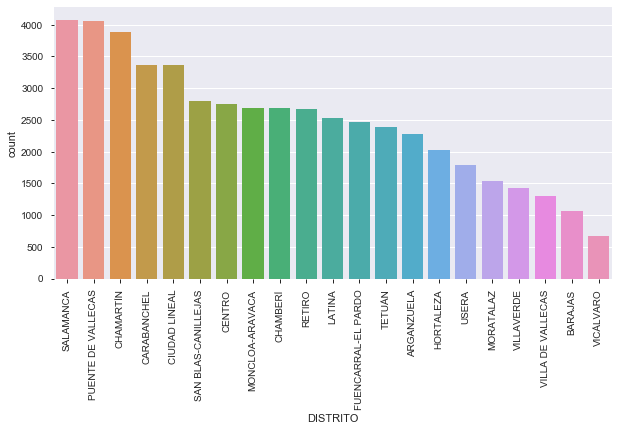

In [55]:
plt.figure(figsize=(10,5))
g = sns.countplot(x="DISTRITO", data=df, order = df['DISTRITO'].value_counts().index)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

**Horario con más accidentes (categorizar por: mañana, tarde, noche)**

In [51]:
df_copia['HORA'] = df_copia['HORA'].astype(int)
df['Tiempo del dia'] = list(range(len(df['HORA'])))

lista = []

for i in df_copia['HORA']:
    if i in range(6,13):
        lista.append('Mañana')
    elif i in range(13,21):
        lista.append('Tarde')
    elif i in range (21,24) or i in range (0,6):
        lista.append('Noche')  

df['Tiempo del dia'] = lista

In [52]:
df['Tiempo del dia'].value_counts().index[0]

'Tarde'

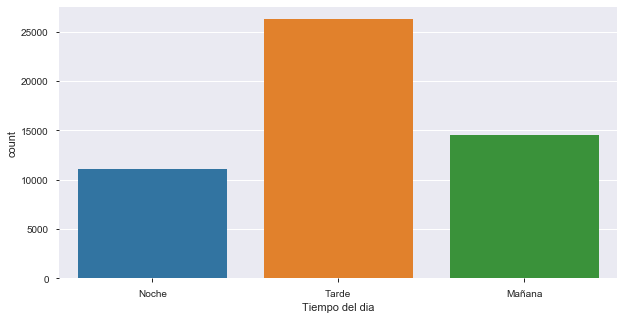

In [53]:
plt.figure(figsize=(10,5))
g = sns.countplot(x="Tiempo del dia", data=df)

**Identificar por distritos tipos de accidentes**

[Text(0, 0, 'Caída'),
 Text(0, 0, 'Colisión fronto-lateral'),
 Text(0, 0, 'Atropello a persona'),
 Text(0, 0, 'Choque contra obstáculo fijo'),
 Text(0, 0, 'Alcance'),
 Text(0, 0, 'Vuelco'),
 Text(0, 0, 'Atropello a animal'),
 Text(0, 0, 'Otro'),
 Text(0, 0, 'Colisión lateral'),
 Text(0, 0, 'Colisión frontal'),
 Text(0, 0, 'Colisión múltiple'),
 Text(0, 0, 'Solo salida de la vía'),
 Text(0, 0, 'Despeñamiento')]

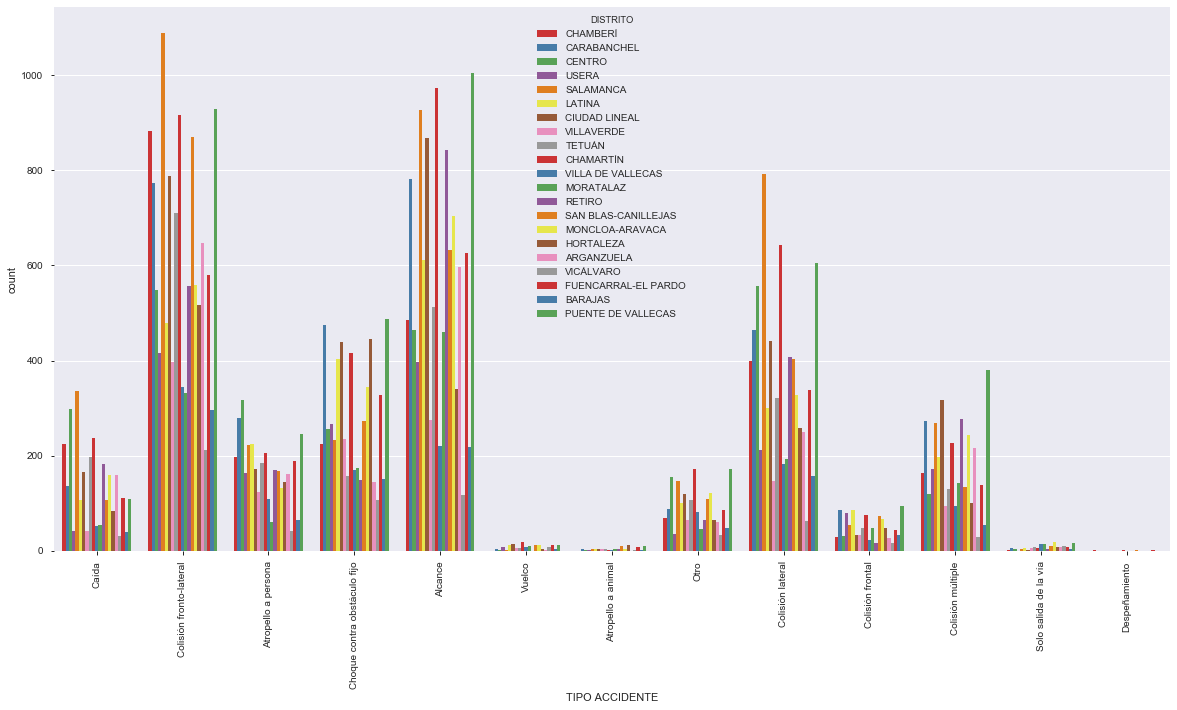

In [56]:
plt.figure(figsize=(20,10))
g = sns.countplot(x="TIPO ACCIDENTE", hue = 'DISTRITO', palette = 'Set1',data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

**Identificar los 3 tramos de edad con más accidentes (graficar)**

[Text(0, 0, 'DE 40 A 44 AÑOS'),
 Text(0, 0, 'DE 25 A 29 AÑOS'),
 Text(0, 0, 'DE 35 A 39 AÑOS')]

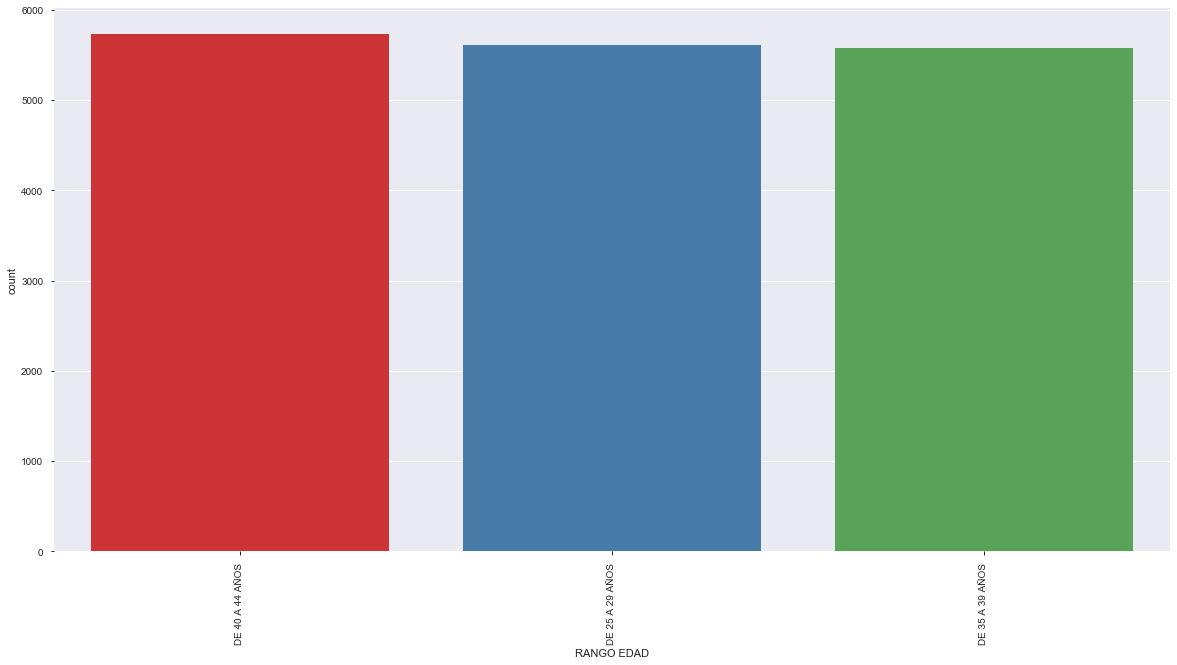

In [57]:
plt.figure(figsize=(20,10))
g = sns.countplot(x="RANGO EDAD", palette = 'Set1',data=df, order = df['RANGO EDAD'].value_counts().iloc[:3].index)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

**Tipos de accidentes que más suceden por distrito**

In [37]:
a = df.groupby('DISTRITO')['TIPO ACCIDENTE']

df.groupby("DISTRITO")["TIPO ACCIDENTE"].value_counts()
df2 = df.groupby('DISTRITO')["TIPO ACCIDENTE"].value_counts().unstack().fillna(0)
df2

TIPO ACCIDENTE,Alcance,Atropello a animal,Atropello a persona,Caída,Choque contra obstáculo fijo,Colisión frontal,Colisión fronto-lateral,Colisión lateral,Colisión múltiple,Despeñamiento,Otro,Solo salida de la vía,Vuelco
DISTRITO,,,,,,,,,,,,,
ARGANZUELA,596.0,0.0,161.0,159.0,145.0,27.0,648.0,249.0,216.0,0.0,60.0,8.0,2.0
BARAJAS,219.0,1.0,64.0,40.0,151.0,34.0,296.0,158.0,53.0,0.0,48.0,3.0,4.0
CARABANCHEL,781.0,3.0,279.0,137.0,474.0,85.0,773.0,465.0,272.0,0.0,88.0,5.0,3.0
CENTRO,464.0,2.0,317.0,297.0,255.0,31.0,549.0,557.0,119.0,0.0,156.0,4.0,1.0
CHAMARTÍN,973.0,2.0,205.0,236.0,415.0,76.0,916.0,644.0,227.0,2.0,172.0,5.0,18.0
CHAMBERÍ,486.0,0.0,197.0,224.0,224.0,29.0,883.0,400.0,164.0,1.0,68.0,2.0,0.0
CIUDAD LINEAL,869.0,4.0,171.0,166.0,438.0,34.0,789.0,440.0,316.0,0.0,119.0,1.0,15.0
FUENCARRAL-EL PARDO,627.0,8.0,189.0,111.0,327.0,44.0,580.0,338.0,139.0,1.0,85.0,8.0,11.0
HORTALEZA,341.0,11.0,144.0,83.0,445.0,48.0,517.0,259.0,101.0,0.0,65.0,7.0,4.0


**Graficar en orden descendente los días de la semana con más accidentes**

[Text(0, 0, 'Friday'),
 Text(0, 0, 'Thursday'),
 Text(0, 0, 'Wednesday'),
 Text(0, 0, 'Tuesday'),
 Text(0, 0, 'Saturday'),
 Text(0, 0, 'Monday'),
 Text(0, 0, 'Sunday')]

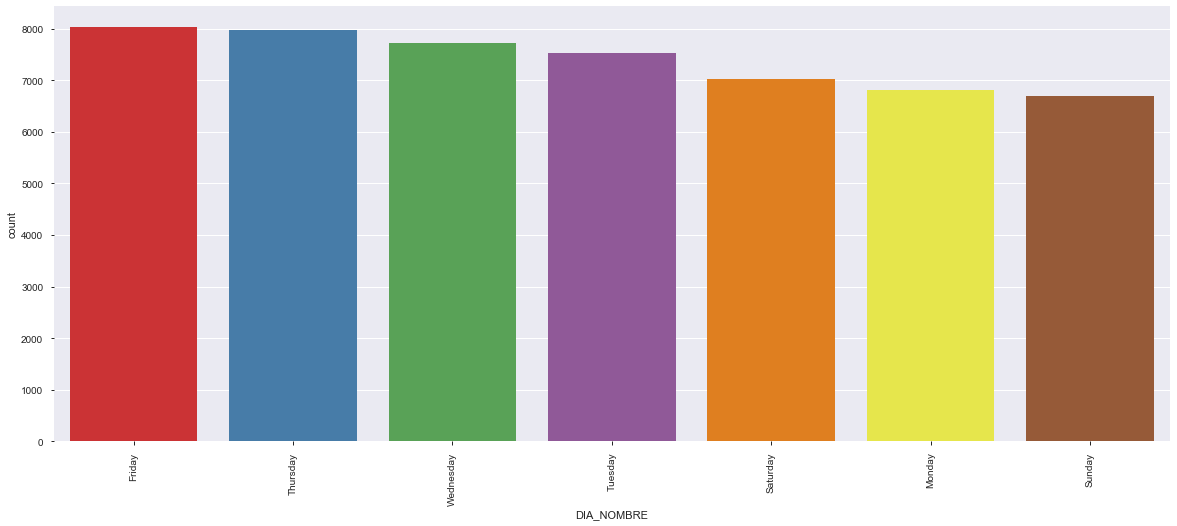

In [28]:
plt.figure(figsize=(20,8))
chart = sns.countplot(
    df['DIA_NOMBRE'],
    
    
    palette='Set1',
    order = df['DIA_NOMBRE'].value_counts().index
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

**Tipo de accidente más común en cada distrito**

In [29]:
a = df.groupby(['DISTRITO'])
a['TIPO ACCIDENTE'].agg(lambda x:x.value_counts().index[0])



DISTRITO
ARGANZUELA             Colisión fronto-lateral
BARAJAS                Colisión fronto-lateral
CARABANCHEL                            Alcance
CENTRO                        Colisión lateral
CHAMARTÍN                              Alcance
CHAMBERÍ               Colisión fronto-lateral
CIUDAD LINEAL                          Alcance
FUENCARRAL-EL PARDO                    Alcance
HORTALEZA              Colisión fronto-lateral
LATINA                                 Alcance
MONCLOA-ARAVACA                        Alcance
MORATALAZ                              Alcance
PUENTE DE VALLECAS                     Alcance
RETIRO                                 Alcance
SALAMANCA              Colisión fronto-lateral
SAN BLAS-CANILLEJAS    Colisión fronto-lateral
TETUÁN                 Colisión fronto-lateral
USERA                  Colisión fronto-lateral
VICÁLVARO              Colisión fronto-lateral
VILLA DE VALLECAS      Colisión fronto-lateral
VILLAVERDE             Colisión fronto-lateral
Name

**Lugar de accidente” con más accidentes por “tipo de accidente**

In [63]:
a = df.groupby(['TIPO ACCIDENTE'])
a['CALLE'].agg(lambda x:x.value_counts().index[0])

TIPO ACCIDENTE
Alcance                                                    PASEO. CASTELLANA
Atropello a animal                                           CALL. SAN DACIO
Atropello a persona                                             CALL. ALCALA
Caída                                                      PASEO. CASTELLANA
Choque contra obstáculo fijo                               PASEO. CASTELLANA
Colisión frontal                CALL. PRINCIPE DE VERGARA / CALL. JORGE JUAN
Colisión fronto-lateral                                    PASEO. CASTELLANA
Colisión lateral                                                CALL. ALCALA
Colisión múltiple                                               CALL. ALCALA
Despeñamiento                                                    CALL. CINCA
Otro                                                       PASEO. CASTELLANA
Solo salida de la vía                    AVDA. PABLO IGLESIAS / CALL. VIVERO
Vuelco                                          AVDA. CANILLE

**Tipo de vehículo” con más accidentes.**

[Text(0, 0, 'Ciclomotor'),
 Text(0, 0, 'Turismo'),
 Text(0, 0, 'Todo terreno'),
 Text(0, 0, 'Bicicleta'),
 Text(0, 0, 'Motocicleta hasta 125cc'),
 Text(0, 0, 'Motocicleta > 125cc'),
 Text(0, 0, 'Autobús'),
 Text(0, 0, 'Furgoneta'),
 Text(0, 0, 'Camión rígido'),
 Text(0, 0, 'Tractocamión'),
 Text(0, 0, 'Maquinaria de obras'),
 Text(0, 0, 'Vehículo articulado'),
 Text(0, 0, 'Cuadriciclo no ligero'),
 Text(0, 0, 'Autobús articulado'),
 Text(0, 0, 'Otros vehículos con motor'),
 Text(0, 0, 'Autocaravana'),
 Text(0, 0, 'Ciclo'),
 Text(0, 0, 'Cuadriciclo ligero'),
 Text(0, 0, 'Semiremolque'),
 Text(0, 0, 'Microbús <= 17 plazas'),
 Text(0, 0, 'Remolque'),
 Text(0, 0, 'Tranvía'),
 Text(0, 0, 'Caravana'),
 Text(0, 0, 'VMU eléctrico'),
 Text(0, 0, 'Otros vehículos sin motor'),
 Text(0, 0, 'Patinete'),
 Text(0, 0, 'Bicicleta EPAC (pedaleo asistido)'),
 Text(0, 0, 'Autobus EMT')]

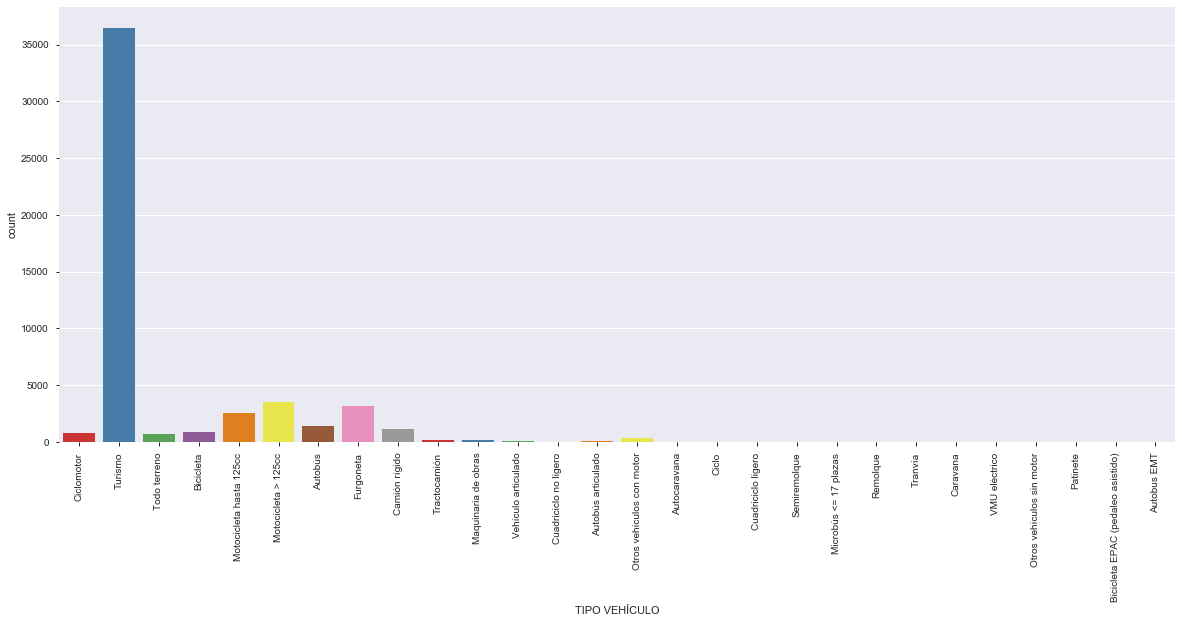

In [31]:
plt.figure(figsize=(20,8))
chart = sns.countplot(df['TIPO VEHÍCULO'],palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

**Número de accidentes en función del tipo de vehículo**

In [32]:
df['TIPO VEHÍCULO'].value_counts()

Turismo                              36499
Motocicleta > 125cc                   3527
Furgoneta                             3125
Motocicleta hasta 125cc               2529
Autobús                               1408
Camión rígido                         1167
Bicicleta                              884
Ciclomotor                             809
Todo terreno                           689
Otros vehículos con motor              330
Tractocamión                           195
Maquinaria de obras                    117
Vehículo articulado                    106
Autobús articulado                      83
Ciclo                                   20
VMU eléctrico                           18
Cuadriciclo ligero                      15
Cuadriciclo no ligero                   14
Autocaravana                            13
Patinete                                 9
Bicicleta EPAC (pedaleo asistido)        7
Otros vehículos sin motor                7
Semiremolque                             5
Autobus EMT

[Text(0, 0, 'Ciclomotor'),
 Text(0, 0, 'Turismo'),
 Text(0, 0, 'Todo terreno'),
 Text(0, 0, 'Bicicleta'),
 Text(0, 0, 'Motocicleta hasta 125cc'),
 Text(0, 0, 'Motocicleta > 125cc'),
 Text(0, 0, 'Autobús'),
 Text(0, 0, 'Furgoneta'),
 Text(0, 0, 'Camión rígido'),
 Text(0, 0, 'Tractocamión'),
 Text(0, 0, 'Maquinaria de obras'),
 Text(0, 0, 'Vehículo articulado'),
 Text(0, 0, 'Cuadriciclo no ligero'),
 Text(0, 0, 'Autobús articulado'),
 Text(0, 0, 'Otros vehículos con motor'),
 Text(0, 0, 'Autocaravana'),
 Text(0, 0, 'Ciclo'),
 Text(0, 0, 'Cuadriciclo ligero'),
 Text(0, 0, 'Semiremolque'),
 Text(0, 0, 'Microbús <= 17 plazas'),
 Text(0, 0, 'Remolque'),
 Text(0, 0, 'Tranvía'),
 Text(0, 0, 'Caravana'),
 Text(0, 0, 'VMU eléctrico'),
 Text(0, 0, 'Otros vehículos sin motor'),
 Text(0, 0, 'Patinete'),
 Text(0, 0, 'Bicicleta EPAC (pedaleo asistido)'),
 Text(0, 0, 'Autobus EMT')]

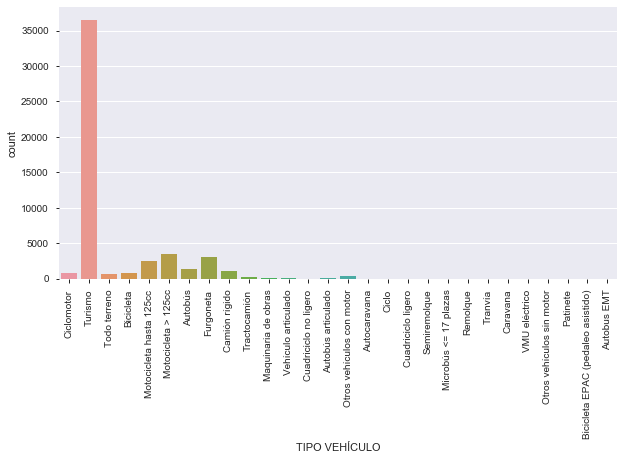

In [33]:
plt.figure(figsize=(10,5))
g = sns.countplot(x="TIPO VEHÍCULO", data=df)
g.set_xticklabels(g.get_xticklabels(),rotation=90)

**Tipo de accidente en función de las condiciones atmosféricas y de la calzada**

In [34]:
a = df.groupby('ESTADO METEREOLÓGICO')
a['TIPO ACCIDENTE'].agg(lambda x: x.value_counts().index[0])

ESTADO METEREOLÓGICO
Despejado         Colisión fronto-lateral
Granizando        Colisión fronto-lateral
LLuvia intensa    Colisión fronto-lateral
Lluvia débil      Colisión fronto-lateral
Nevando                             Caída
Nublado           Colisión fronto-lateral
Name: TIPO ACCIDENTE, dtype: object

**Distrito con más accidentes y que tengan algún grado de lesividad, teniendo un estado meteorológico despejado**

In [65]:
a = df_cat[ (df_cat['LESIVIDAD*'] != 'Sin asistencia sanitaria')& (df_cat['ESTADO METEREOLÓGICO'] == 'Despejado')]
a['DISTRITO'].value_counts()

SALAMANCA              927
CHAMARTÍN              789
PUENTE DE VALLECAS     751
CARABANCHEL            744
CENTRO                 733
RETIRO                 712
CIUDAD LINEAL          686
CHAMBERÍ               665
SAN BLAS-CANILLEJAS    598
LATINA                 576
FUENCARRAL-EL PARDO    551
ARGANZUELA             546
MONCLOA-ARAVACA        544
TETUÁN                 530
HORTALEZA              415
USERA                  402
VILLAVERDE             330
MORATALAZ              315
VILLA DE VALLECAS      237
BARAJAS                201
VICÁLVARO              146
Name: DISTRITO, dtype: int64

**Grado de lesividad según tipo de accidente**

In [66]:
a = df.groupby(['TIPO ACCIDENTE'])
a['LESIVIDAD*'].agg(lambda x:x.value_counts().index[0])

TIPO ACCIDENTE
Alcance                         Sin asistencia sanitaria
Atropello a animal              Sin asistencia sanitaria
Atropello a persona             Sin asistencia sanitaria
Caída                                               LEVE
Choque contra obstáculo fijo    Sin asistencia sanitaria
Colisión frontal                Sin asistencia sanitaria
Colisión fronto-lateral         Sin asistencia sanitaria
Colisión lateral                Sin asistencia sanitaria
Colisión múltiple               Sin asistencia sanitaria
Despeñamiento                   Sin asistencia sanitaria
Otro                            Sin asistencia sanitaria
Solo salida de la vía           Sin asistencia sanitaria
Vuelco                          Sin asistencia sanitaria
Name: LESIVIDAD*, dtype: object

**Horarios más comunes para accidentes según distrito.**

In [68]:
a = df_cat.groupby(['DISTRITO'])
a['HORA'].agg(lambda x:x.value_counts().index[0])

DISTRITO
ARGANZUELA             12:30:00
BARAJAS                18:15:00
CARABANCHEL            14:30:00
CENTRO                 10:00:00
CHAMARTÍN              19:15:00
CHAMBERÍ               19:00:00
CIUDAD LINEAL          20:30:00
FUENCARRAL-EL PARDO    19:30:00
HORTALEZA              09:30:00
LATINA                 18:30:00
MONCLOA-ARAVACA        14:00:00
MORATALAZ              18:00:00
PUENTE DE VALLECAS     17:00:00
RETIRO                 20:00:00
SALAMANCA              16:00:00
SAN BLAS-CANILLEJAS    14:00:00
TETUÁN                 18:00:00
USERA                  21:00:00
VICÁLVARO              22:00:00
VILLA DE VALLECAS      12:45:00
VILLAVERDE             20:10:00
Name: HORA, dtype: object

**Relación entre tramo de edad y sexo**

[Text(0, 0, 'Hombre'), Text(0, 0, 'Mujer')]

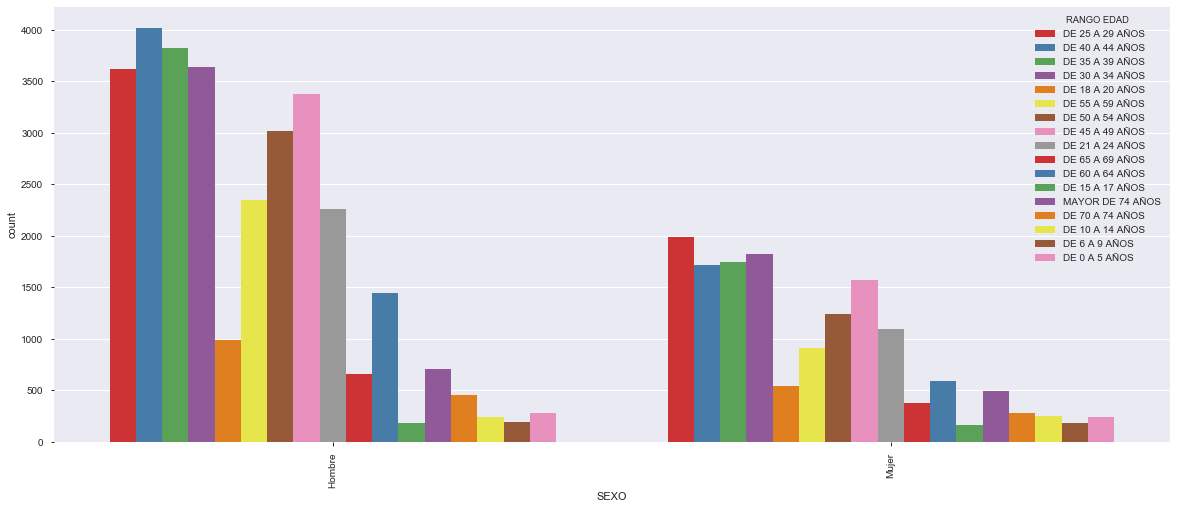

In [35]:

plt.figure(figsize=(20,8))
chart = sns.countplot(
    df['SEXO'],
    hue= df['RANGO EDAD'],
    
    palette='Set1'
)
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

**Día con más accidentes**

In [36]:
df['FECHA'].value_counts()
# Inicio de semana santa, operacion salida

2019-05-04    272
2019-05-31    239
2019-04-24    234
2019-01-02    229
2019-12-20    229
             ... 
2019-08-25     62
2019-07-08     61
2019-04-19     60
2019-08-24     59
2019-08-17     36
Name: FECHA, Length: 365, dtype: int64

**Frecuencia de accidentes en cada distrito**

In [37]:
df['DISTRITO'].value_counts()/(len(df['DISTRITO'])/100)

SALAMANCA              7.871675
PUENTE DE VALLECAS     7.842721
CHAMARTÍN              7.510713
CARABANCHEL            6.495387
CIUDAD LINEAL          6.489596
SAN BLAS-CANILLEJAS    5.398989
CENTRO                 5.312126
MONCLOA-ARAVACA        5.188588
CHAMBERÍ               5.173146
RETIRO                 5.155773
LATINA                 4.879744
FUENCARRAL-EL PARDO    4.763927
TETUÁN                 4.597923
ARGANZUELA             4.383662
HORTALEZA              3.908814
USERA                  3.462919
MORATALAZ              2.953326
VILLAVERDE             2.742926
VILLA DE VALLECAS      2.507432
BARAJAS                2.067328
VICÁLVARO              1.283635
Name: DISTRITO, dtype: float64

**Probabilidad que tiene una moto de sufrir un accidente segun el tipo de accidente y en función de las condiciones atmosféricas**

In [38]:
df['TIPO VEHÍCULO'].unique()

array(['Ciclomotor', 'Turismo', 'Todo terreno', 'Bicicleta',
       'Motocicleta hasta 125cc', 'Motocicleta > 125cc', 'Autobús',
       'Furgoneta', 'Camión rígido', nan, 'Tractocamión',
       'Maquinaria de obras', 'Vehículo articulado',
       'Cuadriciclo no ligero', 'Autobús articulado',
       'Otros vehículos con motor', 'Autocaravana', 'Ciclo',
       'Cuadriciclo ligero', 'Semiremolque', 'Microbús <= 17 plazas',
       'Remolque', 'Tranvía', 'Caravana', 'VMU eléctrico',
       'Otros vehículos sin motor', 'Patinete',
       'Bicicleta EPAC (pedaleo asistido)', 'Autobus EMT'], dtype=object)

In [39]:
df_motocicletas = df[df['TIPO VEHÍCULO'].isin(['Motocicleta hasta 125cc','Motocicleta > 125cc'])]
df_motocicletas.head(2)

,Nº EXPEDIENTE,FECHA,HORA,CALLE,NÚMERO,DISTRITO,TIPO ACCIDENTE,ESTADO METEREOLÓGICO,TIPO VEHÍCULO,TIPO PERSONA,RANGO EDAD,SEXO,LESIVIDAD*,MES,DIA,DIA_NOMBRE
36,2019S000018,2019-01-01,08:25:00,CALL. ALMAGRO / CALL. GENERAL ARRANDO,NaN,CHAMBERÍ,Choque contra obstáculo fijo,Despejado,Motocicleta hasta 125cc,Conductor,DE 25 A 29 AÑOS,NaN,Sin asistencia sanitaria,1,1,Tuesday
37,2019S000018,2019-01-01,08:25:00,CALL. ALMAGRO / CALL. GENERAL ARRANDO,NaN,CHAMBERÍ,Choque contra obstáculo fijo,Despejado,Motocicleta hasta 125cc,Conductor,NaN,NaN,Sin asistencia sanitaria,1,1,Tuesday


In [58]:
estados = list(df_motocicletas['ESTADO METEREOLÓGICO'].unique())

probabilidades = []
estado_prob = []
tipo_acc = []

for i in estados:
    a = df_motocicletas[df_motocicletas['ESTADO METEREOLÓGICO'] == i]
    for j in a['TIPO ACCIDENTE'].value_counts():
        probabilidades.append(j/len(a['TIPO ACCIDENTE']))
        estado_prob.append(i)
    for x,y in a['TIPO ACCIDENTE'].value_counts().iteritems():
        tipo_acc.append(x)
        
f = pd.DataFrame(columns = ['Estado','Accidente','Probabilidad'])
f['Estado'] = estado_prob
f['Probabilidad'] = probabilidades
f['Accidente'] = tipo_acc
f

,Estado,Accidente,Probabilidad
0,Despejado,Colisión fronto-lateral,0.297747
1,Despejado,Caída,0.225289
2,Despejado,Alcance,0.181652
3,Despejado,Colisión lateral,0.145525
4,Despejado,Atropello a persona,0.060077
5,Despejado,Choque contra obstáculo fijo,0.027197
6,Despejado,Colisión múltiple,0.024559
7,Despejado,Otro,0.019890
8,Despejado,Colisión frontal,0.014004
9,Despejado,Solo salida de la vía,0.002639


**Tipo de accidente más común según el tipo de vehículo**

In [41]:
a = df.groupby('TIPO VEHÍCULO')
a['TIPO ACCIDENTE'].agg(lambda x: x.value_counts().index[0])

TIPO VEHÍCULO
Autobus EMT                                   Atropello a persona
Autobús                                   Colisión fronto-lateral
Autobús articulado                        Colisión fronto-lateral
Autocaravana                              Colisión fronto-lateral
Bicicleta                                                   Caída
Bicicleta EPAC (pedaleo asistido)                           Caída
Camión rígido                                    Colisión lateral
Caravana                             Choque contra obstáculo fijo
Ciclo                                                       Caída
Ciclomotor                                                  Caída
Cuadriciclo ligero                        Colisión fronto-lateral
Cuadriciclo no ligero                         Atropello a persona
Furgoneta                                                 Alcance
Maquinaria de obras                              Colisión lateral
Microbús <= 17 plazas                                     Alca

**Número de accidentes en función del clima**

In [42]:
df['ESTADO METEREOLÓGICO'].value_counts()

Despejado         39984
Lluvia débil       3465
Nublado            1862
LLuvia intensa      652
Granizando           14
Nevando               2
Name: ESTADO METEREOLÓGICO, dtype: int64

**Horario y rango de edad donde se producen más accidentes**

In [43]:
df['HORA'].value_counts()

18:00:00    464
19:30:00    457
20:00:00    452
16:00:00    452
18:30:00    441
           ... 
00:33:00      1
08:04:00      1
11:47:00      1
01:08:00      1
06:26:00      1
Name: HORA, Length: 1213, dtype: int64

In [44]:
df['HORA'] = df['HORA'].astype(str)
a = df[df['HORA']== '18:00:00']
a['RANGO EDAD'].agg(lambda x:x.value_counts().index[0])
# 18:00

'DE 40 A 44 AÑOS'

**Horarios donde debería de haber más agentes de transito y en qué lugares específicamente**

In [45]:
a = df.groupby(['DISTRITO'])
a['HORA'].agg(lambda x:x.value_counts().index[0])

DISTRITO
ARGANZUELA             12:30:00
BARAJAS                18:15:00
CARABANCHEL            14:30:00
CENTRO                 10:00:00
CHAMARTÍN              19:15:00
CHAMBERÍ               19:00:00
CIUDAD LINEAL          20:30:00
FUENCARRAL-EL PARDO    19:30:00
HORTALEZA              09:30:00
LATINA                 18:30:00
MONCLOA-ARAVACA        14:00:00
MORATALAZ              18:00:00
PUENTE DE VALLECAS     17:00:00
RETIRO                 20:00:00
SALAMANCA              16:00:00
SAN BLAS-CANILLEJAS    14:00:00
TETUÁN                 18:00:00
USERA                  21:00:00
VICÁLVARO              15:45:00
VILLA DE VALLECAS      12:45:00
VILLAVERDE             20:10:00
Name: HORA, dtype: object

## Predicciones con Machine Learning

**Transformación de variables categóricas a numéricas**

In [16]:
for i in df_cat.columns:
    keys = df_cat[i].unique()
    values = range(len(keys))
    dictionary = dict(zip(keys, values))
    df_cat[i] = df_cat[i].replace(dictionary)

In [17]:
df_cat = df_cat.drop(['MES','DIA','HORA'],axis=1)
df_cat

,DISTRITO,TIPO ACCIDENTE,ESTADO METEREOLÓGICO,TIPO VEHÍCULO,TIPO PERSONA,RANGO EDAD,SEXO,LESIVIDAD*
0,0,0,0,0,0,0,0,0
1,1,1,0,1,0,1,1,1
2,1,1,0,0,0,2,0,2
3,2,1,0,1,0,1,0,1
4,2,1,0,1,0,3,1,0
...,...,...,...,...,...,...,...,...
51801,9,8,0,1,0,4,0,1
51802,9,8,0,1,1,4,1,1
51803,9,8,0,10,0,6,2,1
51804,14,9,0,1,0,9,1,0


In [18]:
df_final = pd.concat((df_copia,df_cat),axis =1)

In [19]:
df_final

,MES,DIA,HORA,DISTRITO,TIPO ACCIDENTE,ESTADO METEREOLÓGICO,TIPO VEHÍCULO,TIPO PERSONA,RANGO EDAD,SEXO,LESIVIDAD*
0,1,1,23,0,0,0,0,0,0,0,0
1,1,1,22,1,1,0,1,0,1,1,1
2,1,1,22,1,1,0,0,0,2,0,2
3,1,1,21,2,1,0,1,0,1,0,1
4,1,1,21,2,1,0,1,0,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...
51801,12,31,01,9,8,0,1,0,4,0,1
51802,12,31,01,9,8,0,1,1,4,1,1
51803,12,31,01,9,8,0,10,0,6,2,1
51804,12,31,00,14,9,0,1,0,9,1,0


### K-FOLD como método de validación

## TRAMO DE EDAD

In [66]:
df_tramoedad = df_final[['MES','DIA','HORA','DISTRITO','TIPO ACCIDENTE','ESTADO METEREOLÓGICO','TIPO VEHÍCULO','TIPO PERSONA','SEXO','LESIVIDAD*']]
X = np.asarray(df_tramoedad)
df_claveedad = df_final['RANGO EDAD']
y = np.asarray(df_claveedad)
y

array([0, 1, 2, ..., 6, 9, 4], dtype=int64)

**Regresión Logística**

In [67]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
scores = cross_val_score(logreg, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))
print("F1-score: ", scores.mean())

F1-score:  0.09192982023524507


**3NN**

In [68]:
from sklearn import neighbors
clf_3nn = neighbors.KNeighborsClassifier(3, weights="distance")
scores = cross_val_score(clf_3nn, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))
print("F1-score: ", scores.mean())


F1-score:  0.08170497262866819


**Perceptron**

In [69]:
from sklearn.linear_model import Perceptron
clf_per = Perceptron(max_iter=2000, random_state=0, n_jobs=2)

scores = cross_val_score(clf_per, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))

print("F1-score: ", scores.mean())

F1-score:  0.0698269424827442


**AdaBoost**

In [70]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=500)
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=10, scoring = make_scorer(f1_score, average="macro"))   #cross_val_score: te da el score (clasificador, dataset X e y, cv =numero de k,scoring=)
scores.mean()

0.08398733121621374

**Random Forest**

In [71]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100, criterion = 'gini')
scores = cross_val_score(clf, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))

print("F1-score: ", scores.mean())

F1-score:  0.13237025706160838


## TIPO ACCIDENTE

In [32]:
df_tipoacc = df_final[['MES','DIA','HORA','DISTRITO','ESTADO METEREOLÓGICO','TIPO VEHÍCULO','TIPO PERSONA','SEXO','LESIVIDAD*','RANGO EDAD']]
X = np.asarray(df_tipoacc)
df_clavetipoac = df_final['TIPO ACCIDENTE']
y = np.asarray(df_clavetipoac)
y

array([0, 1, 1, ..., 8, 9, 9], dtype=int64)

**Regresión Logística**

In [33]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
scores = cross_val_score(logreg, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))
print("F1-score: ", scores.mean())

F1-score:  0.14668940911886635


**3NN**

In [34]:
from sklearn import neighbors
clf_3nn = neighbors.KNeighborsClassifier(3, weights="distance")
scores = cross_val_score(clf_3nn, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))
print("F1-score: ", scores.mean())


F1-score:  0.12150553321698147


**Perceptron**

In [58]:
from sklearn.linear_model import Perceptron
clf_per = Perceptron(max_iter=2000, random_state=0, n_jobs=2)

scores = cross_val_score(clf_per, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))

print("F1-score: ", scores.mean())

F1-score:  0.07145167185711505


**AdaBoost**

In [44]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=500)
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=10, scoring = make_scorer(f1_score, average="macro"))   #cross_val_score: te da el score (clasificador, dataset X e y, cv =numero de k,scoring=)
scores.mean()

0.40246974404163255

**Random Forest**

In [36]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100, criterion = 'gini')
scores = cross_val_score(clf, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))

print("F1-score: ", scores.mean())

F1-score:  0.8539581106334992


## DIA ACCIDENTE

In [62]:
df_dia = df_final[['MES','HORA','DISTRITO','ESTADO METEREOLÓGICO','TIPO ACCIDENTE','TIPO VEHÍCULO','TIPO PERSONA','SEXO','LESIVIDAD*','RANGO EDAD']]
X = np.asarray(df_dia)
df_clavedia = df_final['DIA']
y = np.asarray(df_clavedia)
y

array([ 1,  1,  1, ..., 31, 31, 31], dtype=int64)

**Regresión Logística**

In [36]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
scores = cross_val_score(logreg, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))
print("F1-score: ", scores.mean())

F1-score:  0.018433238053639747


**3NN**

In [37]:
from sklearn import neighbors
clf_3nn = neighbors.KNeighborsClassifier(3, weights="distance")
scores = cross_val_score(clf_3nn, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))
print("F1-score: ", scores.mean())


F1-score:  0.03225321751575259


**Perceptron**

In [61]:
from sklearn.linear_model import Perceptron
clf_per = Perceptron(max_iter=2000, random_state=0, n_jobs=2)

scores = cross_val_score(clf_per, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))

print("F1-score: ", scores.mean())

F1-score:  0.011244591341787949


**AdaBoost**

In [45]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=500)
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=10, scoring = make_scorer(f1_score, average="macro"))   #cross_val_score: te da el score (clasificador, dataset X e y, cv =numero de k,scoring=)
scores.mean()

0.40246974404163255

**Random Forest**

In [63]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 200, criterion = 'gini')
scores = cross_val_score(clf, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))

print("F1-score: ", scores.mean())

F1-score:  0.022215066931565268


## MES ACCIDENTE

In [64]:
df_mes = df_final[['MES','DIA','HORA','DISTRITO','ESTADO METEREOLÓGICO','TIPO ACCIDENTE','TIPO VEHÍCULO','TIPO PERSONA','SEXO','LESIVIDAD*','RANGO EDAD']]
X = np.asarray(df_mes)
df_clavemes = df_final['MES']
y = np.asarray(df_clavemes)
y

array([ 1,  1,  1, ..., 12, 12, 12], dtype=int64)

**Regresión Logística**

In [39]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
scores = cross_val_score(logreg, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))
print("F1-score: ", scores.mean())

F1-score:  0.5275801794312198


**3NN**

In [40]:
from sklearn import neighbors
clf_3nn = neighbors.KNeighborsClassifier(3, weights="distance")
scores = cross_val_score(clf_3nn, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))
print("F1-score: ", scores.mean())


F1-score:  0.2661536970661366


**Perceptron**

In [64]:
from sklearn.linear_model import Perceptron
clf_per = Perceptron(max_iter=2000, random_state=0, n_jobs=2)

scores = cross_val_score(clf_per, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))

print("F1-score: ", scores.mean())

F1-score:  0.20955200371013077


**Random Forest**

In [65]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100, criterion = 'gini')
scores = cross_val_score(clf, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))

print("F1-score: ", scores.mean())

F1-score:  0.857420386106339


## HORARIO ACCIDENTE

In [47]:
lista_numericas = df._get_numeric_data().columns

In [48]:
df_cat = df.drop(lista_numericas, axis=1)
df_cat.head(3)

,Nº EXPEDIENTE,FECHA,HORA,CALLE,NÚMERO,DISTRITO,TIPO ACCIDENTE,ESTADO METEREOLÓGICO,TIPO VEHÍCULO,TIPO PERSONA,RANGO EDAD,SEXO,LESIVIDAD*,DIA_NOMBRE
0,2019S000020,2019-01-01,23:30:00,CALL. FUENCARRAL,149,CHAMBERÍ,Caída,Despejado,Ciclomotor,Conductor,DE 25 A 29 AÑOS,Hombre,LEVE,Tuesday
1,2019S000017,2019-01-01,22:15:00,CALL. OCA / CALL. PINZON,NaN,CARABANCHEL,Colisión fronto-lateral,Despejado,Turismo,Conductor,DE 40 A 44 AÑOS,Mujer,Sin asistencia sanitaria,Tuesday
2,2019S000017,2019-01-01,22:15:00,CALL. OCA / CALL. PINZON,NaN,CARABANCHEL,Colisión fronto-lateral,Despejado,Ciclomotor,Conductor,DE 35 A 39 AÑOS,Hombre,GRAVE,Tuesday


In [49]:
df.head(2)

,Nº EXPEDIENTE,FECHA,HORA,CALLE,NÚMERO,DISTRITO,TIPO ACCIDENTE,ESTADO METEREOLÓGICO,TIPO VEHÍCULO,TIPO PERSONA,RANGO EDAD,SEXO,LESIVIDAD*,MES,DIA,DIA_NOMBRE
0,2019S000020,2019-01-01,23:30:00,CALL. FUENCARRAL,149,CHAMBERÍ,Caída,Despejado,Ciclomotor,Conductor,DE 25 A 29 AÑOS,Hombre,LEVE,1,1,Tuesday
1,2019S000017,2019-01-01,22:15:00,CALL. OCA / CALL. PINZON,NaN,CARABANCHEL,Colisión fronto-lateral,Despejado,Turismo,Conductor,DE 40 A 44 AÑOS,Mujer,Sin asistencia sanitaria,1,1,Tuesday


In [54]:
df_horario = df[['DISTRITO','TIPO ACCIDENTE','ESTADO METEREOLÓGICO','TIPO VEHÍCULO','TIPO PERSONA','RANGO EDAD','SEXO','LESIVIDAD*','Tiempo del dia']]
df_horario.head()

,DISTRITO,TIPO ACCIDENTE,ESTADO METEREOLÓGICO,TIPO VEHÍCULO,TIPO PERSONA,RANGO EDAD,SEXO,LESIVIDAD*,Tiempo del dia
0,CHAMBERÍ,Caída,Despejado,Ciclomotor,Conductor,DE 25 A 29 AÑOS,Hombre,LEVE,Noche
1,CARABANCHEL,Colisión fronto-lateral,Despejado,Turismo,Conductor,DE 40 A 44 AÑOS,Mujer,Sin asistencia sanitaria,Noche
2,CARABANCHEL,Colisión fronto-lateral,Despejado,Ciclomotor,Conductor,DE 35 A 39 AÑOS,Hombre,GRAVE,Noche
3,CENTRO,Colisión fronto-lateral,Despejado,Turismo,Conductor,DE 40 A 44 AÑOS,Hombre,Sin asistencia sanitaria,Noche
4,CENTRO,Colisión fronto-lateral,Despejado,Turismo,Conductor,DE 30 A 34 AÑOS,Mujer,LEVE,Noche


In [55]:
for i in df_horario.columns:
    keys = df_horario[i].unique()
    values = range(len(keys))
    dictionary = dict(zip(keys, values))
    df_horario[i] = df_horario[i].replace(dictionary)

df_horario = pd.concat((df_copia,df_horario,),axis =1)
df_horario.head(2)


,MES,DIA,HORA,DISTRITO,TIPO ACCIDENTE,ESTADO METEREOLÓGICO,TIPO VEHÍCULO,TIPO PERSONA,RANGO EDAD,SEXO,LESIVIDAD*,Tiempo del dia
0,1,1,23,0,0,0,0,0,0,0,0,0
1,1,1,22,1,1,0,1,0,1,1,1,0


In [56]:
df_horario2 = df_horario[['MES','DIA','DISTRITO','ESTADO METEREOLÓGICO','TIPO ACCIDENTE','TIPO VEHÍCULO','TIPO PERSONA','SEXO','LESIVIDAD*','RANGO EDAD']]
X = np.asarray(df_horario2)
df_clavehorario = df_horario['Tiempo del dia']
y = np.asarray(df_clavehorario)
y

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [57]:
df_horario2.head(2)

,MES,DIA,DISTRITO,ESTADO METEREOLÓGICO,TIPO ACCIDENTE,TIPO VEHÍCULO,TIPO PERSONA,SEXO,LESIVIDAD*,RANGO EDAD
0,1,1,0,0,0,0,0,0,0,0
1,1,1,1,0,1,1,0,1,1,1


**Regresión Logística**

In [58]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(solver='lbfgs')
scores = cross_val_score(logreg, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))
print("F1-score: ", scores.mean())

F1-score:  0.2252131423923577


**3NN**

In [59]:
from sklearn import neighbors
clf_3nn = neighbors.KNeighborsClassifier(3, weights="distance")
scores = cross_val_score(clf_3nn, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))
print("F1-score: ", scores.mean())


F1-score:  0.33288846792050053


**AdaBoost**

In [60]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=500)
clf.fit(X, y)
scores = cross_val_score(clf, X, y, cv=10, scoring = make_scorer(f1_score, average="macro"))   #cross_val_score: te da el score (clasificador, dataset X e y, cv =numero de k,scoring=)
scores.mean()

0.3291668139368111

**Random Forest**

In [61]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 100, criterion = 'gini')
scores = cross_val_score(clf, X, y, cv=10, scoring = make_scorer(f1_score, average='macro'))

print("F1-score: ", scores.mean())

F1-score:  0.35150887537046654


### Resultados

Se puede concluir que solo **son efectivas las predicciones** del **tipo de accidente** y **mes del accidente** con el clasificador **Random Forest** por su alta exactitud (entorno a **0.85**).

## RNN Series temporales

In [95]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

Using TensorFlow backend.


### Predecir el tipo de accidente más común que se produce cada día respecto al tiempo (un año)

In [104]:
df_rnn = df[['FECHA','TIPO ACCIDENTE']]

In [105]:
a = df_rnn.groupby(['FECHA'])['TIPO ACCIDENTE'].agg(lambda x:x.value_counts().index[0])

In [106]:
df_rnn = pd.DataFrame(a)

In [107]:
dia = df_rnn.index.tolist()
tipo = [i for i in df_rnn['TIPO ACCIDENTE']]
df_rnn = pd.DataFrame(list(zip(dia, tipo)), columns =['FECHA', 'TIPO ACCIDENTE']) 
df_rnn.head()

,FECHA,TIPO ACCIDENTE
0,2019-01-01,Choque contra obstáculo fijo
1,2019-01-02,Colisión fronto-lateral
2,2019-01-03,Colisión fronto-lateral
3,2019-01-04,Alcance
4,2019-01-05,Colisión fronto-lateral


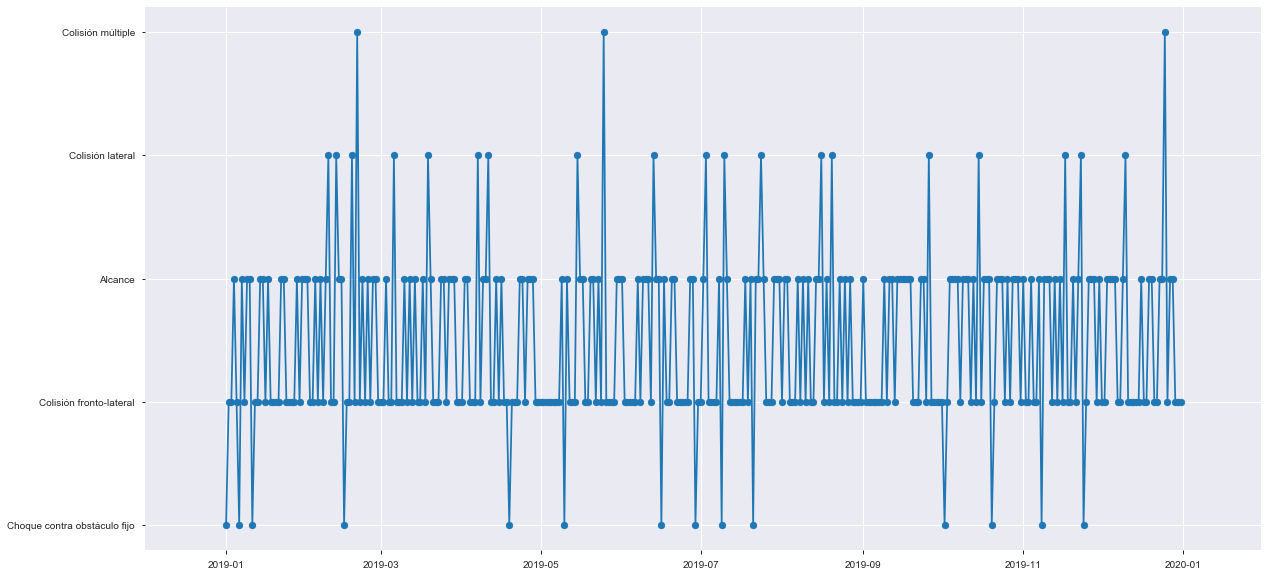

In [109]:
plt.figure(figsize=(20,10)) 
plt.scatter(df_rnn['FECHA'],df_rnn['TIPO ACCIDENTE'])
plt.plot(df_rnn['FECHA'],df_rnn['TIPO ACCIDENTE'])
plt.show()

In [110]:
df_rnn_dummies = df_rnn.copy()
for i in df_rnn_dummies.columns:
    keys = df_rnn_dummies[i].unique()
    values = range(len(keys))
    dictionary = dict(zip(keys, values))
    df_rnn_dummies[i] = df_rnn_dummies[i].replace(dictionary)

In [111]:
df_rnn_dummies['FECHA'] = df_rnn['FECHA']
df_rnn_dummies.head()

,FECHA,TIPO ACCIDENTE
0,2019-01-01,0
1,2019-01-02,1
2,2019-01-03,1
3,2019-01-04,2
4,2019-01-05,1


In [112]:
from sklearn.model_selection import train_test_split

X = df_rnn_dummies[['TIPO ACCIDENTE']].values
train, test = train_test_split(X)
train = X[:int(X.shape[0]*0.7)]
test = X[int(X.shape[0]*0.7):]

In [113]:
#Las RNN requieren de un valor de paso que contiene n número de elementos como secuencia de entrada. 
#lo definimos como un 'step'.
step = 3

def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [114]:
# MODELO
model = Sequential()
model.add(SimpleRNN(500, input_shape=(1,step), activation="relu", unroll=True))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 500)               252000    
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 4008      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 256,017
Trainable params: 256,017
Non-trainable params: 0
_________________________________________________________________


In [115]:
model.fit(trainX,trainY, epochs=1000, batch_size=64, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)

predicted=np.concatenate((trainPredict,testPredict),axis=0)
trainScore = model.evaluate(trainX, trainY, verbose=0)

Epoch 1/1000
 - 0s - loss: 1.7516
Epoch 2/1000
 - 0s - loss: 0.9006
Epoch 3/1000
 - 0s - loss: 0.6712
Epoch 4/1000
 - 0s - loss: 0.7514
Epoch 5/1000
 - 0s - loss: 0.7482
Epoch 6/1000
 - 0s - loss: 0.6769
Epoch 7/1000
 - 0s - loss: 0.6253
Epoch 8/1000
 - 0s - loss: 0.6347
Epoch 9/1000
 - 0s - loss: 0.6336
Epoch 10/1000
 - 0s - loss: 0.6161
Epoch 11/1000
 - 0s - loss: 0.6049
Epoch 12/1000
 - 0s - loss: 0.6021
Epoch 13/1000
 - 0s - loss: 0.5988
Epoch 14/1000
 - 0s - loss: 0.5920
Epoch 15/1000
 - 0s - loss: 0.5878
Epoch 16/1000
 - 0s - loss: 0.5829
Epoch 17/1000
 - 0s - loss: 0.5781
Epoch 18/1000
 - 0s - loss: 0.5732
Epoch 19/1000
 - 0s - loss: 0.5687
Epoch 20/1000
 - 0s - loss: 0.5643
Epoch 21/1000
 - 0s - loss: 0.5598
Epoch 22/1000
 - 0s - loss: 0.5569
Epoch 23/1000
 - 0s - loss: 0.5517
Epoch 24/1000
 - 0s - loss: 0.5478
Epoch 25/1000
 - 0s - loss: 0.5438
Epoch 26/1000
 - 0s - loss: 0.5388
Epoch 27/1000
 - 0s - loss: 0.5335
Epoch 28/1000
 - 0s - loss: 0.5285
Epoch 29/1000
 - 0s - loss: 0

In [264]:
print(trainScore)

0.3983542327787362


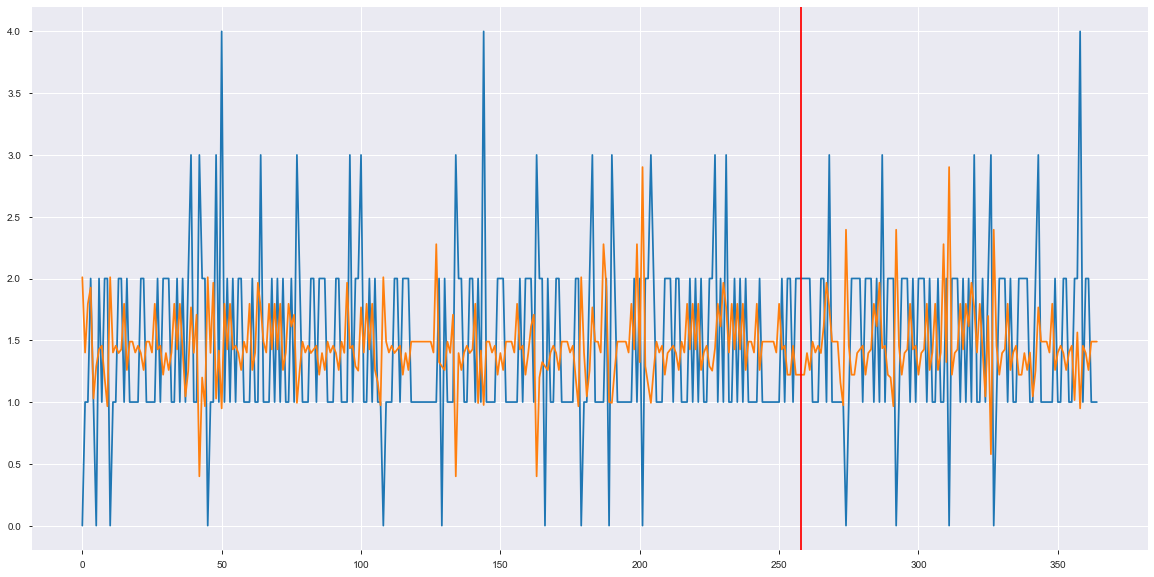

In [117]:
plt.figure(figsize=(20,10)) 
index = df_rnn_dummies['TIPO ACCIDENTE'].index.values
plt.plot(index,df_rnn_dummies['TIPO ACCIDENTE'])
plt.plot(index,predicted)
plt.axvline(df_rnn_dummies['TIPO ACCIDENTE'].index[len(train)], c="r")
plt.show()

La **prediccion de la serie temporal** esta marcada con **color naranja** y los **valores reales** con **color azul**. La **linea vertical roja** delimita la **separación** entre los **datos de entrenamiento y test** utilizados. 

Se puede deducir que la predicción del **número de accidentes según el tipo de accidente  más común a lo largo del tiempo** es **poco eficaz** **(0.3985 sobre 1 de eficacia)** pero se podría intentar mejorar la predicción si se añaden datos de más años.

### Predecir el rango de edad que sufre más accidentes cada día respecto al tiempo(un año)

In [118]:
df_rnn = df[['FECHA','RANGO EDAD']]

In [119]:
a = df_rnn.groupby(['FECHA'])['RANGO EDAD'].agg(lambda x:x.value_counts().index[0])

In [120]:
df_rnn = pd.DataFrame(a)

In [121]:
dia = df_rnn.index.tolist()
tipo = [i for i in df_rnn['RANGO EDAD']]
df_rnn = pd.DataFrame(list(zip(dia, tipo)), columns =['FECHA', 'RANGO EDAD']) 
df_rnn.head()

,FECHA,RANGO EDAD
0,2019-01-01,DE 21 A 24 AÑOS
1,2019-01-02,DE 40 A 44 AÑOS
2,2019-01-03,DE 35 A 39 AÑOS
3,2019-01-04,DE 40 A 44 AÑOS
4,2019-01-05,DE 21 A 24 AÑOS


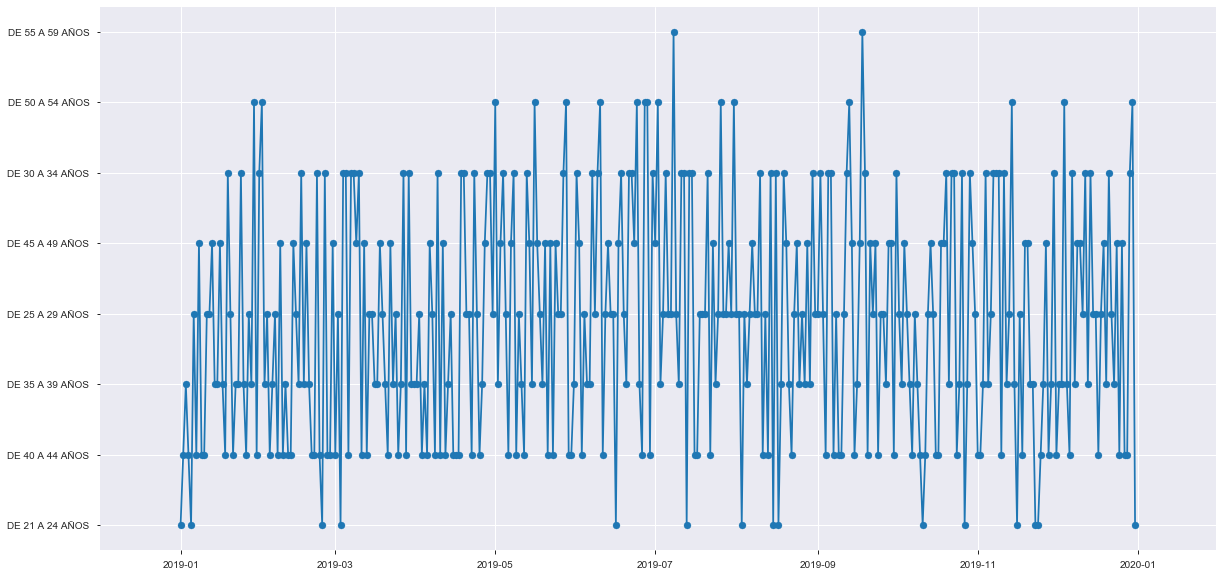

In [122]:
plt.figure(figsize=(20,10)) 
plt.scatter(df_rnn['FECHA'],df_rnn['RANGO EDAD'])
plt.plot(df_rnn['FECHA'],df_rnn['RANGO EDAD'])
plt.show()

In [123]:
df_rnn_dummies = df_rnn.copy()
for i in df_rnn_dummies.columns:
    keys = df_rnn_dummies[i].unique()
    values = range(len(keys))
    dictionary = dict(zip(keys, values))
    df_rnn_dummies[i] = df_rnn_dummies[i].replace(dictionary)

In [124]:
df_rnn_dummies['FECHA'] = df_rnn['FECHA']
df_rnn_dummies.head()

,FECHA,RANGO EDAD
0,2019-01-01,0
1,2019-01-02,1
2,2019-01-03,2
3,2019-01-04,1
4,2019-01-05,0


In [125]:
from sklearn.model_selection import train_test_split

X = df_rnn_dummies[['RANGO EDAD']].values
train, test = train_test_split(X)
train = X[:int(X.shape[0]*0.7)]
test = X[int(X.shape[0]*0.7):]

In [126]:
step = 3

def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [127]:
# MODELO
model = Sequential()
model.add(SimpleRNN(500, input_shape=(1,step), activation="relu", unroll=True))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, 500)               252000    
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 4008      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 256,017
Trainable params: 256,017
Non-trainable params: 0
_________________________________________________________________


In [128]:
model.fit(trainX,trainY, epochs=1000, batch_size=64, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)

predicted=np.concatenate((trainPredict,testPredict),axis=0)
trainScore = model.evaluate(trainX, trainY, verbose=0)

Epoch 1/1000
 - 0s - loss: 8.1002
Epoch 2/1000
 - 0s - loss: 5.3210
Epoch 3/1000
 - 0s - loss: 3.5709
Epoch 4/1000
 - 0s - loss: 3.3233
Epoch 5/1000
 - 0s - loss: 3.5273
Epoch 6/1000
 - 0s - loss: 3.5101
Epoch 7/1000
 - 0s - loss: 3.2928
Epoch 8/1000
 - 0s - loss: 3.1384
Epoch 9/1000
 - 0s - loss: 3.1405
Epoch 10/1000
 - 0s - loss: 3.1571
Epoch 11/1000
 - 0s - loss: 3.1286
Epoch 12/1000
 - 0s - loss: 3.0910
Epoch 13/1000
 - 0s - loss: 3.0566
Epoch 14/1000
 - 0s - loss: 3.0523
Epoch 15/1000
 - 0s - loss: 3.0492
Epoch 16/1000
 - 0s - loss: 3.0237
Epoch 17/1000
 - 0s - loss: 3.0123
Epoch 18/1000
 - 0s - loss: 3.0001
Epoch 19/1000
 - 0s - loss: 2.9864
Epoch 20/1000
 - 0s - loss: 2.9830
Epoch 21/1000
 - 0s - loss: 2.9671
Epoch 22/1000
 - 0s - loss: 2.9519
Epoch 23/1000
 - 0s - loss: 2.9423
Epoch 24/1000
 - 0s - loss: 2.9377
Epoch 25/1000
 - 0s - loss: 2.9190
Epoch 26/1000
 - 0s - loss: 2.9095
Epoch 27/1000
 - 0s - loss: 2.8980
Epoch 28/1000
 - 0s - loss: 2.8997
Epoch 29/1000
 - 0s - loss: 2

In [281]:
print(trainScore)

2.958264333126592


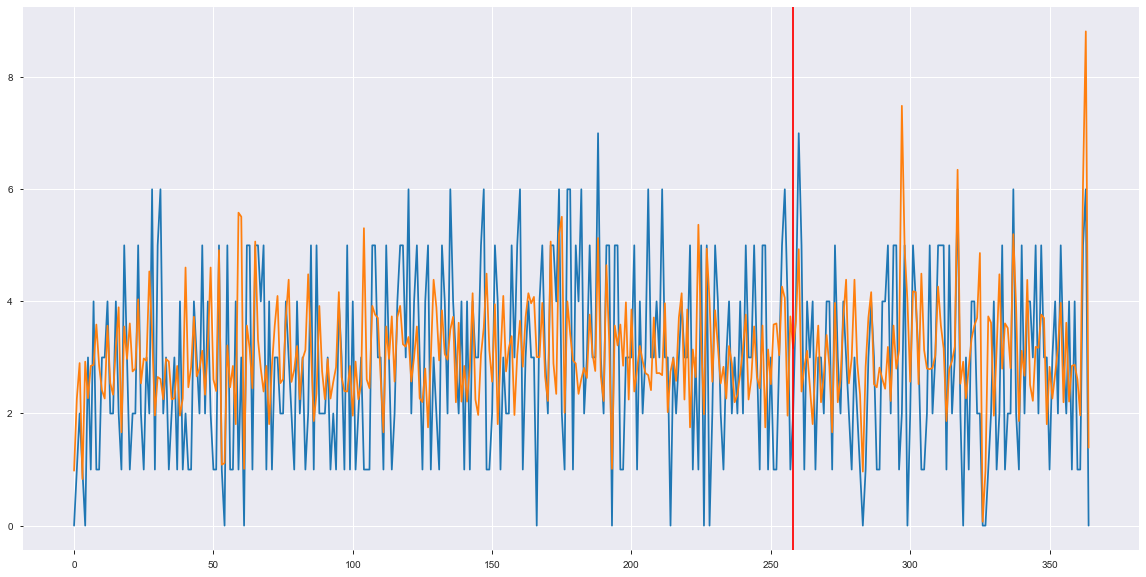

In [129]:
index = df_rnn_dummies['RANGO EDAD'].index.values
plt.figure(figsize=(20,10)) 
plt.plot(index,df_rnn_dummies['RANGO EDAD'])
plt.plot(index,predicted)
plt.axvline(df_rnn_dummies['RANGO EDAD'].index[len(train)], c="r")
plt.show()

El **rango de edad**, al igual que en las predicciones, **no nos proporciona un resultado eficaz**

### Predecir el distrito donde se producen cada día más accidentes respecto al tiempo (un año)

In [130]:
df_rnn = df[['FECHA','DISTRITO']]

In [131]:
a = df_rnn.groupby(['FECHA'])['DISTRITO'].agg(lambda x:x.value_counts().index[0])

In [132]:
df_rnn = pd.DataFrame(a)

In [133]:
dia = df_rnn.index.tolist()
tipo = [i for i in df_rnn['DISTRITO']]
df_rnn = pd.DataFrame(list(zip(dia, tipo)), columns =['FECHA', 'DISTRITO']) 
df_rnn.head()

,FECHA,DISTRITO
0,2019-01-01,CARABANCHEL
1,2019-01-02,SALAMANCA
2,2019-01-03,CHAMARTÍN
3,2019-01-04,SAN BLAS-CANILLEJAS
4,2019-01-05,PUENTE DE VALLECAS


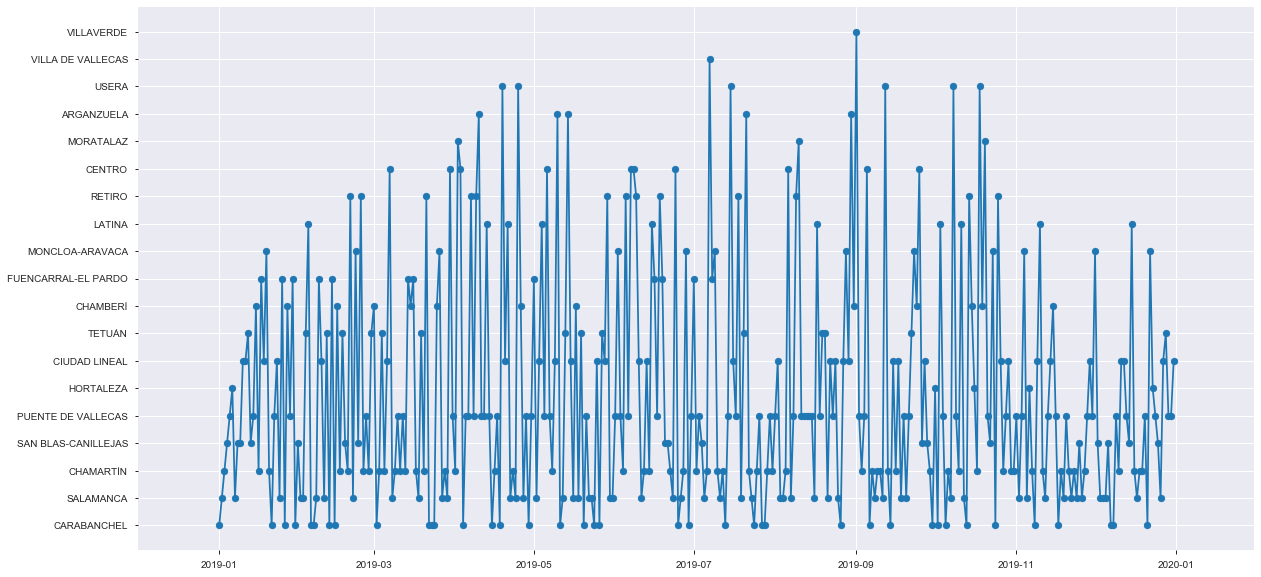

In [134]:
plt.figure(figsize=(20,10)) 
plt.scatter(df_rnn['FECHA'],df_rnn['DISTRITO'])
plt.plot(df_rnn['FECHA'],df_rnn['DISTRITO'])
plt.show()

In [135]:
df_rnn_dummies = df_rnn.copy()
for i in df_rnn_dummies.columns:
    keys = df_rnn_dummies[i].unique()
    values = range(len(keys))
    dictionary = dict(zip(keys, values))
    df_rnn_dummies[i] = df_rnn_dummies[i].replace(dictionary)

In [136]:
df_rnn_dummies['FECHA'] = df_rnn['FECHA']
df_rnn_dummies.head()

,FECHA,DISTRITO
0,2019-01-01,0
1,2019-01-02,1
2,2019-01-03,2
3,2019-01-04,3
4,2019-01-05,4


In [137]:
from sklearn.model_selection import train_test_split

X = df_rnn_dummies[['DISTRITO']].values
train, test = train_test_split(X)
train = X[:int(X.shape[0]*0.7)]
test = X[int(X.shape[0]*0.7):]

In [138]:
step = 3

def convertToMatrix(data, step):
    X, Y =[], []
    for i in range(len(data)-step):
        d=i+step  
        X.append(data[i:d,])
        Y.append(data[d,])
    return np.array(X), np.array(Y)

# add step elements into train and test
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [139]:
# MODELO
model = Sequential()
model.add(SimpleRNN(500, input_shape=(1,step), activation="relu", unroll=True))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 500)               252000    
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 4008      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 9         
Total params: 256,017
Trainable params: 256,017
Non-trainable params: 0
_________________________________________________________________


In [140]:
model.fit(trainX,trainY, epochs=1000, batch_size=64, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)

predicted=np.concatenate((trainPredict,testPredict),axis=0)
trainScore = model.evaluate(trainX, trainY, verbose=0)

Epoch 1/1000
 - 0s - loss: 46.1241
Epoch 2/1000
 - 0s - loss: 42.0816
Epoch 3/1000
 - 0s - loss: 38.2039
Epoch 4/1000
 - 0s - loss: 34.3607
Epoch 5/1000
 - 0s - loss: 31.2952
Epoch 6/1000
 - 0s - loss: 28.6171
Epoch 7/1000
 - 0s - loss: 26.7547
Epoch 8/1000
 - 0s - loss: 26.0147
Epoch 9/1000
 - 0s - loss: 25.9386
Epoch 10/1000
 - 0s - loss: 26.1260
Epoch 11/1000
 - 0s - loss: 26.0875
Epoch 12/1000
 - 0s - loss: 25.8685
Epoch 13/1000
 - 0s - loss: 25.5881
Epoch 14/1000
 - 0s - loss: 25.4293
Epoch 15/1000
 - 0s - loss: 25.3781
Epoch 16/1000
 - 0s - loss: 25.3333
Epoch 17/1000
 - 0s - loss: 25.2563
Epoch 18/1000
 - 0s - loss: 25.1882
Epoch 19/1000
 - 0s - loss: 25.1149
Epoch 20/1000
 - 0s - loss: 25.0546
Epoch 21/1000
 - 0s - loss: 24.9796
Epoch 22/1000
 - 0s - loss: 24.9226
Epoch 23/1000
 - 0s - loss: 24.9039
Epoch 24/1000
 - 0s - loss: 24.8068
Epoch 25/1000
 - 0s - loss: 24.7392
Epoch 26/1000
 - 0s - loss: 24.6623
Epoch 27/1000
 - 0s - loss: 24.5970
Epoch 28/1000
 - 0s - loss: 24.5481
E

In [141]:
print(trainScore)

12.552498364916035


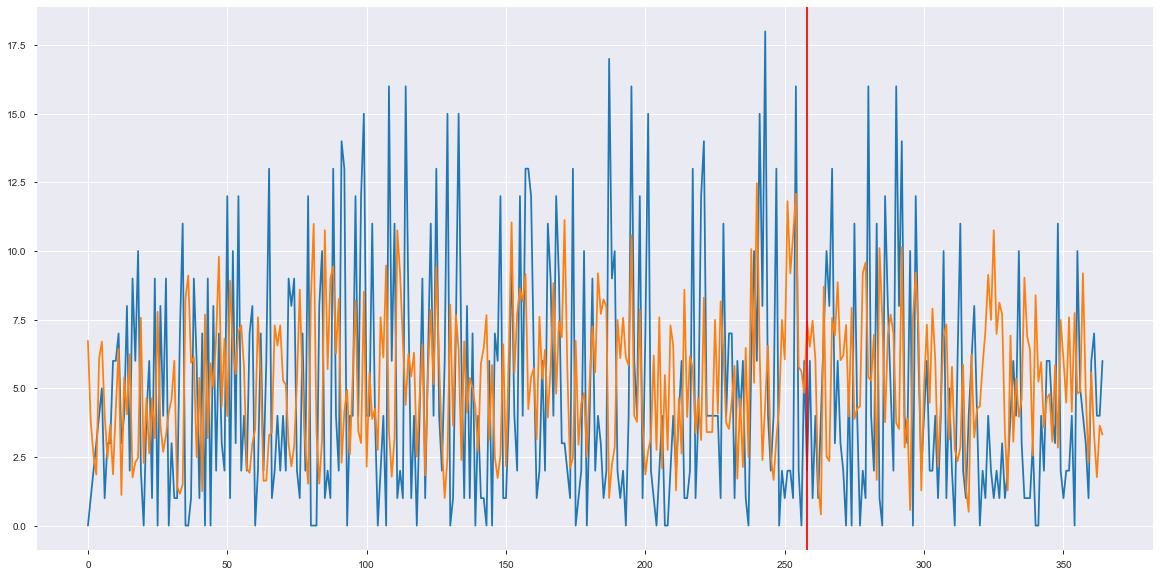

In [142]:
index = df_rnn_dummies['DISTRITO'].index.values
plt.figure(figsize=(20,10)) 
plt.plot(index,df_rnn_dummies['DISTRITO'])
plt.plot(index,predicted)
plt.axvline(df_rnn_dummies['DISTRITO'].index[len(train)], c="r")
plt.show()

Igual que con el rango de edad, **el atributo distrito no nos proporciona un resultado eficaz**. Esto **puede deberse**, en general, **por la utilización de variables categóricas**, siendo **menos efectivas/representativas** en la predicción de series temporales.